In [15]:
import numpy 
import pyximport

pyximport.install(setup_args={"include_dirs":numpy.get_include()},
                  reload_support=True)
from utils_loc import gradient
import numpy as np 
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.transform import warp
from scipy.fftpack import fftn, ifftn
from scipy.ndimage.interpolation import map_coordinates

%matplotlib inline

# FFT on pytorch

In [3]:
img = rgb2gray(plt.imread('Q9jiI1pL_400x400.jpg'))
tr_img = torch.from_numpy(img).unsqueeze(2).cuda()
fft_img_tr = torch.cat((tr_img, torch.zeros_like(tr_img)), 2)

In [4]:
fft_img = fftn(img)

In [47]:
momentum = tr_img.unsqueeze(-1)
tr_momentum = torch.cat((momentum, torch.zeros_like(momentum)), -1).unsqueeze(0)
G = torch.zeros(tr_momentum.shape)
print(G.shape)
for i in range(0, len(tr_momentum)):
    print(torch.fft(tr_momentum[i], len(momentum.shape[1:])).shape)
    G[i] = torch.fft(tr_momentum[i], len(momentum.shape[1:]))
    

torch.Size([1, 384, 384, 1, 2])
torch.Size([384, 384, 1, 2])


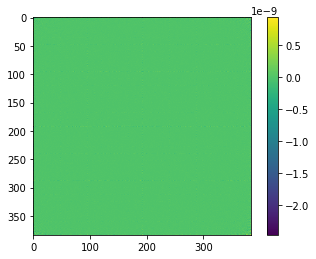

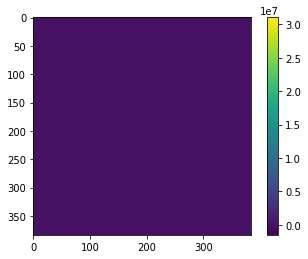

In [12]:
plt.imshow(torch.fft(fft_img_tr, 2)[:,:,0].cpu().numpy()-np.real(fft_img));
plt.colorbar();
plt.show();
plt.imshow(np.real(fft_img));
plt.colorbar();

# warp skimage

In [56]:
import pymrt as mrt
import pymrt.geometry


 ____        __  __ ____ _____
|  _ \ _   _|  \/  |  _ \_   _|
| |_) | | | | |\/| | |_) || |
|  __/| |_| | |  | |  _ < | |
|_|    \__, |_|  |_|_| \_\|_|
       |___/



In [3]:
def bilinear_grid_sample(image, grid, dtype=torch.cuda.DoubleTensor):
    samples = grid.type(dtype)
    
    if image.ndimension() == 2:
        image = image.type(dtype).permute(0,1)  
        W, H = image.shape
        samples = samples.permute(2,1,0).unsqueeze(0)
            
        samples[:,:,:,0] /=(W-1)
        samples[:,:,:,1] /=(H-1)

    elif image.ndimension() == 3:
        image = image.type(dtype).permute(2,0,1)
        D, H, W = image.shape
        samples = samples.permute(1,2,3,0).unsqueeze(0)
        samples[:,:,:,:,0] /= (W-1) # normalize to between  0 and 1
        samples[:,:,:,:,1] /= (H-1) # normalize to between  0 and 1
        samples[:,:,:,:,2] /= (D-1)
        
        
    image = image.unsqueeze(0).unsqueeze(0)
    
    samples = 2*samples-1  
    
    return torch.nn.functional.grid_sample(image, samples).squeeze(0).squeeze(0)

# 2D image 

In [4]:
img = rgb2gray(plt.imread('Q9jiI1pL_400x400.jpg'))

shape = img.shape
mapping = np.mgrid[tuple(map(slice, shape))][:,0::2,0::2]

In [6]:
warp_2d = warp(img, mapping)
tr_2d = bilinear_grid_sample(torch.from_numpy(img), torch.from_numpy(mapping))

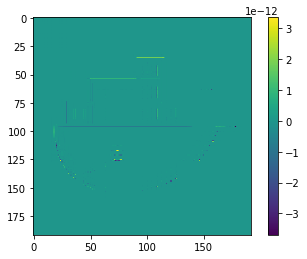

In [7]:
plt.imshow(warp_2d - tr_2d.cpu().numpy());
plt.colorbar();

# 3D image

In [8]:
shape = (50,50,20)
img = mrt.geometry.sphere(shape, 8).astype('int32')
mapping = np.mgrid[tuple(map(slice, shape))][:,0::2,0::2,0::2]

In [9]:
warp_3d = warp(img, mapping)
tr_3d = bilinear_grid_sample(torch.from_numpy(img), torch.from_numpy(mapping))

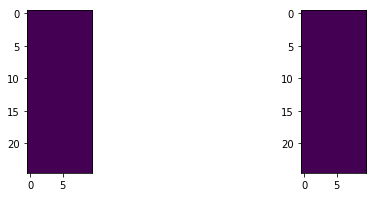

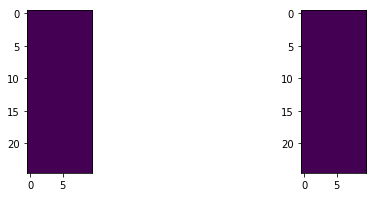

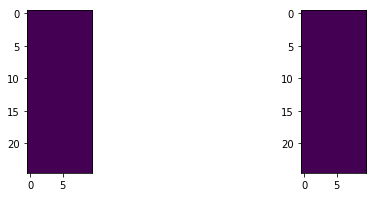

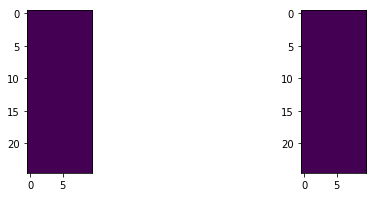

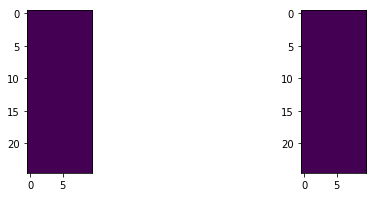

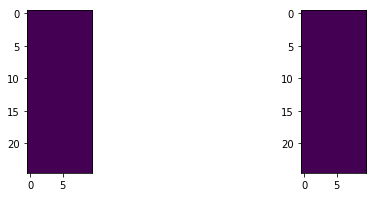

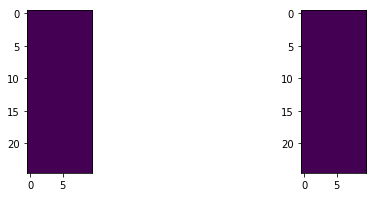

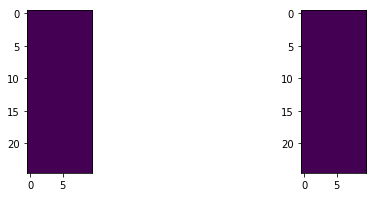

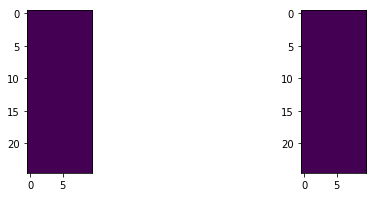

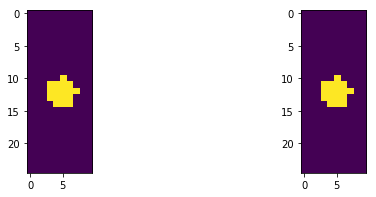

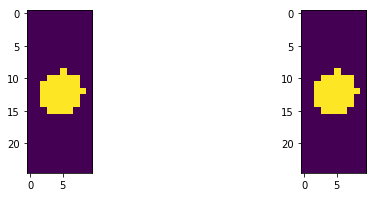

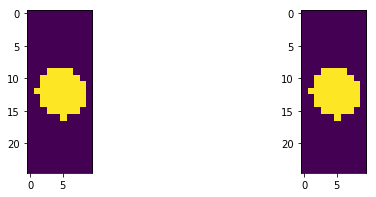

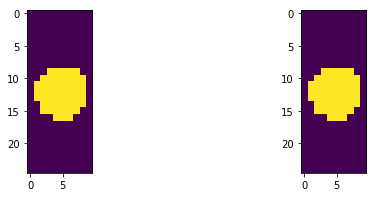

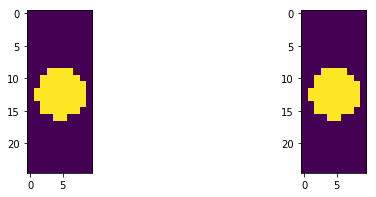

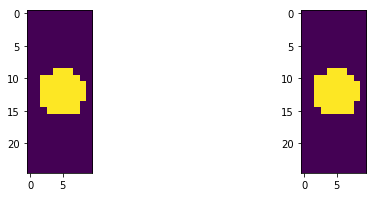

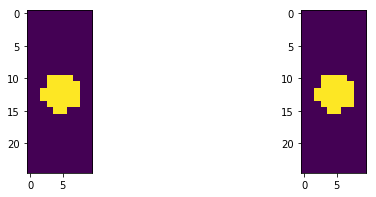

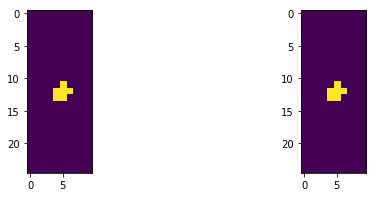

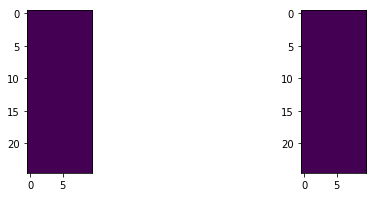

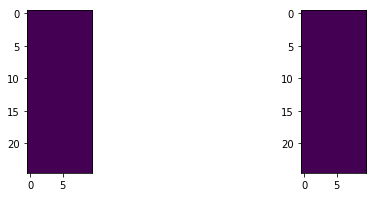

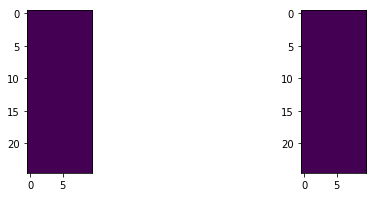

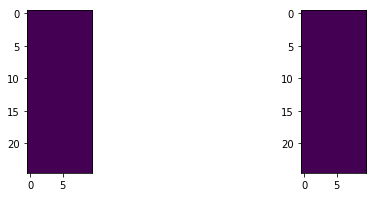

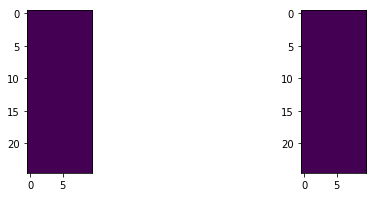

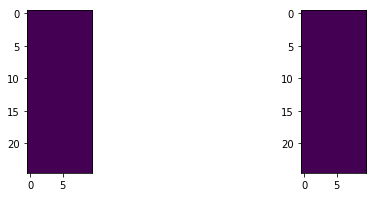

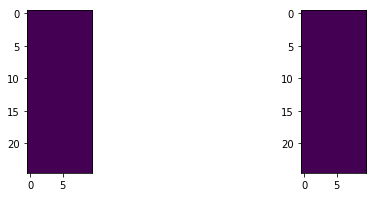

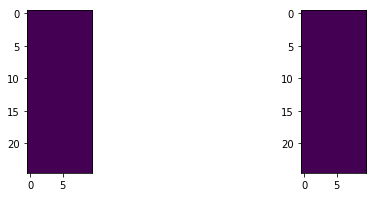

In [10]:
for i in range(len(warp_3d)):
    plt.figure(figsize=(9,3))
    plt.subplot(121)
    plt.imshow(warp_3d[i]);
    plt.subplot(122)
    plt.imshow(tr_3d.cpu().numpy()[i]);
    plt.show();

# interpolation

In [156]:
def bilinear_interpolate_torch(im, x, y):
    ' interpolate image im with grid x and y'
    dtype_long = torch.cuda.LongTensor
    dtype = torch.cuda.FloatTensor
    x0 = torch.floor(x).type(dtype_long)
    x1 = x0 + 1
    
    y0 = torch.floor(y).type(dtype_long)
    y1 = y0 + 1

    x0 = torch.clamp(x0, 0, im.shape[1]-1)
    x1 = torch.clamp(x1, 0, im.shape[1]-1)
    y0 = torch.clamp(y0, 0, im.shape[0]-1)
    y1 = torch.clamp(y1, 0, im.shape[0]-1)
   
    Ia = im[ x0, y0 ]
    Ib = im[ x1, y0 ]
    Ic = im[ x0, y1 ]
    Id = im[ x1, y1 ]
    
    wa = (x1.type(dtype)-x) * (y1.type(dtype)-y)
    wb = (x1.type(dtype)-x) * (y-y0.type(dtype))
    wc = (x-x0.type(dtype)) * (y1.type(dtype)-y)
    wd = (x-x0.type(dtype)) * (y-y0.type(dtype))

    return torch.t((torch.t(Ia)*wa)) + torch.t(torch.t(Ib)*wb) + torch.t(torch.t(Ic)*wc) + torch.t(torch.t(Id)*wd)

In [3]:
def trilinear_interpolation_torch(img, x, y, z):

    dtype_long = torch.cuda.LongTensor
    dtype = torch.cuda.DoubleTensor
    x0 = torch.floor(x)
    x1 = x0.type(torch.LongTensor) + 1
    y0 = torch.floor(y)
    y1 = y0.type(torch.LongTensor) + 1
    z0 = torch.floor(z)
    z1 = z0.type(torch.LongTensor) + 1

    dx = (x - x0).type(dtype).cuda()
    dy = (y - y0).type(dtype).cuda()
    dz = (z - z0).type(dtype).cuda()
    
    x0 = x0.type(torch.LongTensor)
    y0 = y0.type(torch.LongTensor)
    z0 = z0.type(torch.LongTensor)
    
    x0 = torch.clamp(x0, 0, img.shape[0]-1)
    x1 = torch.clamp(x1, 0, img.shape[0]-1)
    y0 = torch.clamp(y0, 0, img.shape[1]-1)
    y1 = torch.clamp(y1, 0, img.shape[1]-1)
    z0 = torch.clamp(z0, 0, img.shape[2]-1)
    z1 = torch.clamp(z1, 0, img.shape[2]-1)
   
    
    
    Ia = img[x0, y0, z0]
    Ib = img[x0, y0, z1]
    Ic = img[x0, y1, z0]
    Id = img[x0, y1, z1]
    If = img[x1, y0, z0]
    Ie = img[x1, y0, z1]
    Ig = img[x1, y1, z0]
    Ih = img[x1, y1, z1]
    
#     res = (1-dx)*(1-dy)*(1-dz)*Ih + (1-dx) *(1-dy)*dz*Ig 
#     res += (1-dx)*dy*(1-dz)*Ie + (1-dx)*dy*dz*If
#     res += dx*(1-dy)*(1-dz)*Id + dx*(1-dy)*dz*Ic
#     res += dx*dy*(1-dz)*Ib + dx*dy*dz*Ia
    
    res = (1-dx)*(1-dy)*(1-dz)*Ia + (1-dx) *(1-dy)*dz*Ib 
    res += (1-dx)*dy*(1-dz)*Ic + (1-dx)*dy*dz*Id
    res += dx*(1-dy)*(1-dz)*If + dx*(1-dy)*dz*Ie
    res += dx*dy*(1-dz)*Ig + dx*dy*dz*Ih
    
    return res

In [45]:
def upsample_interp(img, size):
    if img.ndimension() == 3:
        return F.interpolate(img.unsqueeze(0).unsqueeze(0), size=size, mode='trilinear', align_corners=True)
    if img.ndimension() == 2:
        return F.interpolate(img.unsqueeze(0).unsqueeze(0), size=size, mode='bilinear', align_corners=True)

In [51]:
shape = (8,5,5)
grid = torch.cuda.DoubleTensor(np.mgrid[tuple(map(slice, shape))])

In [52]:
size = (4,2,2)
up_2d = upsample_interp(grid[0], size)
map_2d = interpolate_mapping(grid[0].cpu().numpy(), np.array(list(size)).astype('int32'))

In [53]:
up_2d

tensor([[[[[0.0000, 0.0000],
           [0.0000, 0.0000]],

          [[2.3333, 2.3333],
           [2.3333, 2.3333]],

          [[4.6667, 4.6667],
           [4.6667, 4.6667]],

          [[7.0000, 7.0000],
           [7.0000, 7.0000]]]]], device='cuda:0', dtype=torch.float64)

In [54]:
map_2d

array([[[0.        , 0.        ],
        [0.        , 0.        ]],

       [[2.33333333, 2.33333333],
        [2.33333333, 2.33333333]],

       [[4.66666667, 4.66666667],
        [4.66666667, 4.66666667]],

       [[7.        , 7.        ],
        [7.        , 7.        ]]])

Gradinets torch version:

## 1D grads 

In [2]:
a = torch.from_numpy(np.random.randint(0, 10, 10**6).astype('float64')).cuda()
a_np = a.cpu().numpy()

In [3]:
def gradient1D(img):
    if img.ndimension() == 1:
        img = img.unsqueeze(0).unsqueeze(0)
    img_pad = F.pad(img, (1,1), mode='replicate')
    conv = torch.nn.Conv1d(1,1,kernel_size=(1,3), bias=False)
    conv.weight.data = torch.from_numpy(np.array([[[-1/2.,0,1/2.]]],dtype='float64')).cuda()
    conv.weight.requires_grad = False
    
    
    model_x = torch.nn.Sequential(conv)
    model_x.cuda()
    res = model_x(img_pad).squeeze(0).squeeze(0)
    res[0] *=2
    res[-1] *=2
    
    return res

In [4]:
tr_1d = torch.cat(((a[1] - a[0]).unsqueeze(0), 0.5*(a[2:] - a[:-2]), (a[-1] - a[-2]).unsqueeze(0)))
conv1d = gradient1D(a)
grad = gradient(a_np)
print(np.allclose(tr_1d.cpu().numpy(), grad), np.allclose(conv1d.cpu().numpy(),grad))

True True


In [5]:
a_pad = F.pad(a.unsqueeze(0).unsqueeze(0), (1,1), mode='replicate')
conv = torch.nn.Conv1d(1,1,kernel_size=(1,3), bias=False)
conv.weight.data = torch.from_numpy(np.array([[[-1/2.,0,1/2.]]],dtype='float64')).cuda()
conv.weight.requires_grad = False
model_x = torch.nn.Sequential(conv)
model_x.cuda()

Sequential(
  (0): Conv1d(1, 1, kernel_size=(1, 3), stride=(1,), bias=False)
)

In [6]:
%%timeit
res = model_x(a_pad)
res[0] *=2
res[-1] *=2

1.86 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit 
tr_d1 = torch.cat(((a[1] - a[0]).unsqueeze(0), 0.5*(a[2:] - a[:-2]), (a[-1] - a[-2]).unsqueeze(0)))

206 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit 
grad = gradient(a_np)

1.86 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2D grads 

In [29]:
a = torch.from_numpy(np.random.randint(0, 10, (8*10**3,8*10**3)).astype('float64')).cuda()
a_np = a.cpu().numpy()

In [30]:
grad = gradient(a_np)

In [31]:
a_pad = F.pad(a.unsqueeze(0).unsqueeze(0),(1,1,1,1), mode='replicate')

In [32]:
conv_y = torch.nn.Conv2d(1, 1, kernel_size=(1,3), bias=False)
conv_y.weight.data = torch.from_numpy(np.array([[[[-1/2., 0, 1/2.]]]], dtype='float64')).cuda()
conv_y.weight.require_grads = False

conv_x = torch.nn.Conv2d(1, 1, kernel_size=(3,1), bias=False)
conv_x.weight.data = torch.from_numpy(np.array([[[[-1/2.], [0.], [1/2.]]]], dtype='float64')).cuda()
conv_x.weight.require_grads = False

In [33]:
model_x = torch.nn.Sequential(conv_x)
model_y = torch.nn.Sequential(conv_y)
model_x.cuda()
model_y.cuda()
a_pad.cuda()

tensor([[[[1., 1., 6.,  ..., 9., 6., 6.],
          [1., 1., 6.,  ..., 9., 6., 6.],
          [9., 9., 9.,  ..., 5., 3., 3.],
          ...,
          [6., 6., 0.,  ..., 9., 0., 0.],
          [3., 3., 0.,  ..., 3., 4., 4.],
          [3., 3., 0.,  ..., 3., 4., 4.]]]],
       device='cuda:0', dtype=torch.float64)

In [34]:
a_pad.cuda()
a_x = model_x(a_pad)[:,:,:,1:-1]
a_y = model_y(a_pad)[:,:,1:-1,:]

a_y[:,:,:,0] *= 2
a_y[:,:,:,-1] *= 2

a_x[:,:,0,:] *= 2
a_x[:,:,-1,:] *= 2

RuntimeError: CUDA error: out of memory

In [ ]:
np.allclose(a_x.cpu().detach().numpy(), grad[0]), np.allclose(a_y.cpu().detach().numpy(), grad[1])

In [15]:
grad.shape

(2, 8000, 8000)

In [11]:
a_pad_y = F.pad(a.unsqueeze(0).unsqueeze(0),(0,0,1,1), mode='replicate')
a_pad_x = F.pad(a.unsqueeze(0).unsqueeze(0),(1,1,0,0), mode='replicate')

conv_y = torch.nn.Conv2d(1, 1, kernel_size=(1,3), bias=False)
conv_y.weight.data = torch.from_numpy(np.array([[[[-1/2., 0, 1/2.]]]], dtype='float64')).cuda()
conv_y.weight.require_grads = False

conv_x = torch.nn.Conv2d(1,1, kernel_size=(3,1), bias=False)
conv_x.weight.data = torch.from_numpy(np.array([[[[-1/2.], [0.], [1/2.]]]], dtype='float64')).cuda()
conv_x.weight.require_grads = False

In [13]:
model_x = torch.nn.Sequential(conv_x)
model_y = torch.nn.Sequential(conv_y)

model_x.cuda()
model_y.cuda()
a_pad_x.cuda(), a_pad_y.cuda()

(tensor([[[[2., 2., 6.,  ..., 6., 7., 7.],
           [1., 1., 8.,  ..., 9., 0., 0.],
           [4., 4., 5.,  ..., 0., 9., 9.],
           ...,
           [8., 8., 8.,  ..., 8., 6., 6.],
           [7., 7., 9.,  ..., 2., 8., 8.],
           [5., 5., 7.,  ..., 5., 9., 9.]]]],
        device='cuda:0', dtype=torch.float64),
 tensor([[[[2., 6., 7.,  ..., 4., 6., 7.],
           [2., 6., 7.,  ..., 4., 6., 7.],
           [1., 8., 4.,  ..., 4., 9., 0.],
           ...,
           [7., 9., 3.,  ..., 6., 2., 8.],
           [5., 7., 6.,  ..., 9., 5., 9.],
           [5., 7., 6.,  ..., 9., 5., 9.]]]],
        device='cuda:0', dtype=torch.float64))

In [54]:
a_x = model_x(a_pad_x)
a_y = model_y(a_pad_y)

NameError: name 'a_pad_x' is not defined

In [16]:
np.allclose(a_x.cpu().detach().numpy(), grad[1]),np.allclose(a_y.cpu().detach().numpy(), grad[0])

(True, True)

In [53]:
torch.cat((a_y, a_x), dim=1).shape, grad.shape

(torch.Size([8000, 16000]), (2, 8000, 8000))

In [19]:
%%timeit
model_x(a_pad_x)
model_y(a_pad_y)

202 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
conv_x(a_pad_x)
conv_y(a_pad_y)

202 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit
grad = gradient(a_np)

475 ms ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 3D grads

In [2]:
a = torch.from_numpy(np.random.randint(0, 10, (3*10**2,3*10**2, 3*10**2)).astype('float64')).cuda()
a_np = a.cpu().numpy()

In [3]:
grad = gradient(a_np)

In [4]:
a_pad = F.pad(a.unsqueeze(0).unsqueeze(0),(1,1,1,1,1,1), mode='replicate')
conv_x = torch.nn.Conv3d(1, 1, kernel_size=(3,1,1), bias=False)
conv_x.weight.data = torch.from_numpy(np.array([[[[[-1/2.]], [[0.]], [[1/2.]]]]], dtype='float64')).cuda()
conv_x.weight.require_grads = False

conv_y = torch.nn.Conv3d(1,1, kernel_size=(1,3,1), bias=False)
conv_y.weight.data = torch.from_numpy(np.array([[[[[-1/2.], [0.], [1/2.]]]]], dtype='float64')).cuda()
conv_y.weight.require_grads = False


conv_z = torch.nn.Conv3d(1,1, kernel_size=(1,1,3), bias=False)
conv_z.weight.data = torch.from_numpy(np.array([[[[[-1/2., 0., 1/2.]]]]], dtype='float64')).cuda()
conv_z.weight.require_grads = False

model_x = torch.nn.Sequential(conv_x)
model_y = torch.nn.Sequential(conv_y)
model_z = torch.nn.Sequential(conv_z)

model_x.cuda()
model_y.cuda()
model_z.cuda()
a_pad.cuda()

tensor([[[[[8., 8., 7.,  ..., 3., 1., 1.],
           [8., 8., 7.,  ..., 3., 1., 1.],
           [0., 0., 0.,  ..., 8., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 7., 3., 3.],
           [7., 7., 0.,  ..., 3., 0., 0.],
           [7., 7., 0.,  ..., 3., 0., 0.]],

          [[8., 8., 7.,  ..., 3., 1., 1.],
           [8., 8., 7.,  ..., 3., 1., 1.],
           [0., 0., 0.,  ..., 8., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 7., 3., 3.],
           [7., 7., 0.,  ..., 3., 0., 0.],
           [7., 7., 0.,  ..., 3., 0., 0.]],

          [[8., 8., 0.,  ..., 4., 8., 8.],
           [8., 8., 0.,  ..., 4., 8., 8.],
           [2., 2., 5.,  ..., 0., 8., 8.],
           ...,
           [3., 3., 5.,  ..., 0., 3., 3.],
           [2., 2., 9.,  ..., 8., 4., 4.],
           [2., 2., 9.,  ..., 8., 4., 4.]],

          ...,

          [[6., 6., 2.,  ..., 1., 4., 4.],
           [6., 6., 2.,  ..., 1., 4., 4.],
           [6., 6., 7.,  ..., 6., 7., 7.],
           ...,
           

In [6]:
a_x = model_x(a_pad)[:,:,:,1:-1,1:-1]
a_x[:,:,0,:,:] *= 2
a_x[:,:, -1,:,:] *= 2


a_y = model_y(a_pad)[:,:,1:-1,:,1:-1]
a_y[:,:,:,0,:] *= 2
a_y[:,:,:,-1,:] *= 2

a_z = model_z(a_pad)[:,:,1:-1,1:-1,:]
a_z[:,:,:,:,0] *= 2
a_z[:,:,:,:,-1] *= 2

np.allclose(a_z.cpu().detach().numpy(), grad[2]), np.allclose(a_y.cpu().detach().numpy(), grad[1]), np.allclose(a_x.cpu().detach().numpy(), grad[0])

(True, True, True)

In [4]:
a_pad_x = F.pad(a.unsqueeze(0).unsqueeze(0),(0,0,0,0,1,1), mode='replicate')
a_pad_y = F.pad(a.unsqueeze(0).unsqueeze(0),(0,0,1,1,0,0), mode='replicate')
a_pad_z = F.pad(a.unsqueeze(0).unsqueeze(0),(1,1,0,0,0,0), mode='replicate')


conv_x = torch.nn.Conv3d(1, 1, kernel_size=(3,1,1), bias=False)
conv_x.weight.data = torch.from_numpy(np.array([[[[[-1/2.]], [[0.]], [[1/2.]]]]], dtype='float64')).cuda()
conv_x.weight.require_grads = False

conv_y = torch.nn.Conv3d(1,1, kernel_size=(1,3,1), bias=False)
conv_y.weight.data = torch.from_numpy(np.array([[[[[-1/2.], [0.], [1/2.]]]]], dtype='float64')).cuda()
conv_y.weight.require_grads = False


conv_z = torch.nn.Conv3d(1,1, kernel_size=(1,1,3), bias=False)
conv_z.weight.data = torch.from_numpy(np.array([[[[[-1/2., 0., 1/2.]]]]], dtype='float64')).cuda()
conv_z.weight.require_grads = False

In [5]:
model_x = torch.nn.Sequential(conv_x)
model_y = torch.nn.Sequential(conv_y)
model_z = torch.nn.Sequential(conv_z)

model_x.cuda()
model_y.cuda()
model_z.cuda()
a_pad_x.cuda(), a_pad_y.cuda(), a_pad_z.cuda()
print()

In [6]:
a_x = model_x(a_pad_x)
a_x = a_x.squeeze(0).squeeze(0)
a_x[0,:,:] *= 2
a_x[-1,:,:] *= 2
np.allclose(a_x.cpu().detach().numpy(), grad[0])

True

In [7]:
a_y = model_y(a_pad_y)
a_y = a_y.squeeze(0).squeeze(0)
a_y[:,0,:] *= 2
a_y[:,-1,:] *= 2

np.allclose(a_y.cpu().detach().numpy(), grad[1])

True

In [9]:
a_z = model_z(a_pad_z)
a_z = a_z.squeeze(0).squeeze(0)
a_z[:,:,0] *= 2
a_z[:,:,-1] *= 2

np.allclose(a_z.cpu().detach().numpy(), grad[2])

True

In [11]:
%%timeit
conv_x(a_pad_x)
conv_y(a_pad_y)
conv_z(a_pad_z)

134 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
a_x = model_x(a_pad_x)
a_y = model_y(a_pad_y)
a_z = model_z(a_pad_z)

135 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%%timeit
a_x = model_x(a_pad_x)
#a_x = a_x.squeeze(0).squeeze(0)
a_x[0,0,0,:,:] *= 2
a_x[0,0,-1,:,:] *= 2

a_y = model_y(a_pad_y)
#a_y = a_y.squeeze(0).squeeze(0)
a_y[0,0,:,0,:] *= 2
a_y[0,0,:,-1,:] *= 2

a_z = model_z(a_pad_z)
#a_z = a_z.squeeze(0).squeeze(0)
a_z[0,0,:,:,0] *= 2
a_z[0,0,:,:,-1] *= 2

134 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
grad = gradient(a_np)

352 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
def kernel(ndim):

    if ndim == 2:
        conv_y = torch.nn.Conv2d(1, 1, kernel_size=(1, 3), bias=False)
        conv_y.weight.data = torch.from_numpy(np.array([[[[-1 / 2., 0, 1 / 2.]]]], dtype='float64')).cuda()
        conv_y.weight.require_grads = False

        conv_x = torch.nn.Conv2d(1, 1, kernel_size=(3, 1), bias=False)
        conv_x.weight.data = torch.from_numpy(np.array([[[[-1 / 2.], [0.], [1 / 2.]]]], dtype='float64')).cuda()
        conv_x.weight.require_grads = False

        model_x = torch.nn.Sequential(conv_x)
        model_y = torch.nn.Sequential(conv_y)

        model_x.cuda()
        model_y.cuda()

        return [model_x, model_y, None]

    if ndim == 3:
        conv_x = torch.nn.Conv3d(1, 1, kernel_size=(3, 1, 1), bias=False)
        conv_x.weight.data = torch.from_numpy(np.array([[[[[-1 / 2.]], [[0.]], [[1 / 2.]]]]], dtype='float64')).cuda()
        conv_x.weight.require_grads = False

        conv_y = torch.nn.Conv3d(1, 1, kernel_size=(1, 3, 1), bias=False)
        conv_y.weight.data = torch.from_numpy(np.array([[[[[-1 / 2.], [0.], [1 / 2.]]]]], dtype='float64')).cuda()
        conv_y.weight.require_grads = False

        conv_z = torch.nn.Conv3d(1, 1, kernel_size=(1, 1, 3), bias=False)
        conv_z.weight.data = torch.from_numpy(np.array([[[[[-1 / 2., 0., 1 / 2.]]]]], dtype='float64')).cuda()
        conv_z.weight.require_grads = False

        model_x = torch.nn.Sequential(conv_x)
        model_y = torch.nn.Sequential(conv_y)
        model_z = torch.nn.Sequential(conv_z)

        model_x.cuda()
        model_y.cuda()
        model_z.cuda()

        return [model_x, model_y, model_z]

In [4]:
def torch_gradient(img, model_x, model_y, model_z=None):
    ndim = img.ndimension()
    img = img.unsqueeze(0).unsqueeze(0)
    #    assert ndim < 3, "Not invalid dimension, minimum supported (1,1, xlen)"

    if ndim == 1:
        return torch.cat(((img[:, :, 1] - img[:, :, 0]).unsqueeze(0),
                          0.5 * (img[:, :, 2:] - img[:, :, :-2]),
                          (img[:, :, -1] - img[:, :, -2]).unsqueeze(0)), dim=2)
    if ndim == 2:
        img_pad = F.pad(img, (1, 1, 1, 1), mode='replicate')
        img_pad.cuda()

        img_x = model_x(img_pad)[:, :, :, 1:-1]
        img_y = model_y(img_pad)[:, :, 1:-1, :]

        img_y[:, :, :, 0] *= 2
        img_y[:, :, :, -1] *= 2

        img_x[:, :, 0, :] *= 2
        img_x[:, :, -1, :] *= 2

        return torch.cat((img_x, img_y), dim=1).squeeze(0)
    if ndim == 3:
        img_pad = F.pad(img, (1, 1, 1, 1, 1, 1), mode='replicate')
        img_pad.cuda()

        img_x = model_x(img_pad)[:, :, :, 1:-1, 1:-1]
        img_y = model_y(img_pad)[:, :, 1:-1, :, 1:-1]
        img_z = model_z(img_pad)[:, :, 1:-1, 1:-1, :]

        img_x[:, :, 0, :, :] *= 2
        img_x[:, :, -1, :, :] *= 2

        img_y[:, :, :, 0, :] *= 2
        img_y[:, :, :, -1, :] *= 2

        img_z[:, :, :, :, 0] *= 2
        img_z[:, :, :, :, -1] *= 2

        return torch.cat((img_x, img_y, img_z), dim=1).squeeze(0)


In [10]:
a = torch.from_numpy(np.random.rand(100,100)).cuda()
a_np = a.cpu().numpy()

In [11]:
tr_grad = torch_gradient(a, *kernel(a.ndimension()))
grad = gradient(a_np)

In [14]:
np.allclose(tr_grad.cpu().detach().numpy(), grad)

True

# Gaussian filter

In [87]:
def gaussian_filter(img, kernel_size=3, sigma=1., ndim=None):
    if ndim == None:
        ndim = img.ndimension()
        if ndim != 2 and ndim !=3:
            raise "Input error, invalid dimention of image"
    
    if type(kernel_size) == float or type(kernel_size) == int:
        kernel = (kernel_size,) * ndim
    else:
        kernel = kernel_size

    grid = torch.from_numpy(identity_mapping(kernel).numpy().T).type(torch.FloatTensor)

    mean = (kernel_size - 1) / 2.
    variance = sigma ** 2.
    gaussian_kernel = (1. / (2. * np.pi * variance)) * \
                      torch.exp(
                          -torch.sum((grid - mean) ** 2., dim=-1) / \
                          (2 * variance)
                      )
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    if ndim == 2:
        g_filter = torch.nn.Conv2d(in_channels=1, out_channels=1,
                                          kernel_size=kernel, bias=False,
                                          padding=1)

    if ndim == 3:
        g_filter = torch.nn.Conv3d(in_channels=1, out_channels=1,
                                          kernel_size=kernel, bias=False,
                                          padding=1)
    
    g_filter.weight.data = gaussian_kernel.unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)
    g_filter.weight.requires_grad = False

    return g_filter(img.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

In [98]:
a = np.random.rand(5,5).reshape(5,5)
torch.sum(torch.from_numpy(a), dim=-1)

tensor([2.0552, 2.0673, 2.3862, 3.0107, 1.1346], dtype=torch.float64)

In [88]:
def identity_mapping(shape):
    return torch.FloatTensor(np.mgrid[tuple(map(slice, shape))])

In [89]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [93]:
img = torch.from_numpy(rgb2gray(plt.imread('Q9jiI1pL_400x400.jpg', ))).type(torch.FloatTensor)
# nd_img = gaussian_filter(img, 1.)
tr_2d = gaussian_filter(img)
tr_3d = gaussian_filter(img)

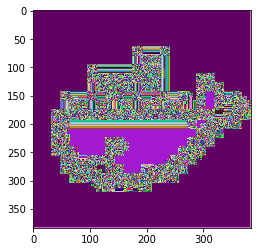

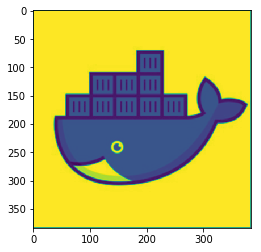

In [94]:
plt.imshow(tr_3d);
plt.show();
plt.imshow(tr_2d);

torch upsample 

In [3]:
vector_fields = torch.from_numpy(np.random.normal(size=(2,5,5)))
resolution=2
order='nearest'
shape = (5,5)
ratio = tuple([int(ax/resolution) for ax in shape])
ndim = 3
data = torch.nn.functional.upsample(vector_fields.unsqueeze(0), scale_factor=(resolution,)*2, mode='bilinear').squeeze(0)

/nmnt/media/home/ayagoz/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/nmnt/media/home/ayagoz/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch einsum ??!!

In [90]:
shape = (2,5,5)
J = np.random.normal(size=shape)
vector_fields = np.random.uniform(size=(5,) + shape)

In [91]:
np_ein = np.einsum('ij...,j...->i...', J, vector_fields)

In [92]:
np_ein.shape

(2, 2, 5, 5)

In [93]:
torch_ein = torch.einsum('ij...,j...->i...',
                                [torch.from_numpy(J),
                                torch.from_numpy(vector_fields)])

RuntimeError: ellipsis must represent 1 dimensions in all terms

In [78]:
a = torch.rand(32, 48, 9, 3)
print(np.einsum('...ji,...jk->...ik', a, a).shape)
# (32, 48, 3, 3)

print(torch.einsum('...ji,...jk->...ik', [a, a]).shape)

(32, 48, 3, 3)
torch.Size([32, 48, 3, 3])


Create grid in pytorch

In [15]:
shape = (5,5)
grid = identity_mapping(shape)

In [21]:
grid.clone().type(torch.float)

tensor([[[0., 0., 0.],
         [1., 1., 1.],
         [2., 2., 2.]],

        [[0., 1., 2.],
         [0., 1., 2.],
         [0., 1., 2.]]])

Test det in pytorch

In [8]:
N=10*5
A = np.random.normal(4, 1., size=(N,N)) + 100*np.eye(N)
A_t = torch.from_numpy(A).cuda()

In [9]:
%%timeit
torch.from_numpy(A)

1.05 µs ± 10.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%%timeit
np.linalg.det(A)

32.6 µs ± 5.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
torch.eig(A_t)

3.12 ms ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit
torch.potrf(A_t).diag().prod()

863 µs ± 6.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%timeit
torch.det(A_t)

469 µs ± 957 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Test det in tensor version for 2D

In [17]:
N = 10**3
dim = 2
size = (dim,)*2 +  (N,)*2
J = np.random.normal(size=size)
J_t = torch.from_numpy(J).cuda()

In [18]:
%%timeit
det2D = J[0, 0] * J[1, 1] - J[0, 1] * J[1, 0]

4.07 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
det2D_t = J_t[0, 0] * J_t[1, 1] - J_t[0, 1] * J_t[1, 0]

276 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Test det in tensor version for 3D

In [20]:
N = 10**2
dim = 3
size = (dim,)*2 +  (N,)*3
J = np.random.normal(size=size)
J_t = torch.from_numpy(J).cuda()

In [21]:
%%timeit
det3D = (J[0, 0] * J[1, 1] * J[2, 2]
                + J[1, 0] * J[2, 1] * J[0, 2]
                + J[0, 1] * J[1, 2] * J[2, 0]
                - J[0, 0] * J[1, 2] * J[2, 1]
                - J[2, 2] * J[1, 0] * J[0, 1]
                - J[0, 2] * J[1, 1] * J[2, 0])

20.5 ms ± 83 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
det3D_t = (J_t[0, 0] * J_t[1, 1] * J_t[2, 2]
                + J_t[1, 0] * J_t[2, 1] * J_t[0, 2]
                + J_t[0, 1] * J_t[1, 2] * J_t[2, 0]
                - J_t[0, 0] * J_t[1, 2] * J_t[2, 1]
                - J_t[2, 2] * J_t[1, 0] * J_t[0, 1]
                - J_t[0, 2] * J_t[1, 1] * J_t[2, 0])

1.56 ms ± 78 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Test upsampling| grid_sample| zoom

In [3]:
def identity_mapping(shape):
    return np.mgrid[tuple(map(slice, shape))]

In [4]:
def bilinear_grid_sample(image, grid_x, grid_y):
    image = image.permute(0,1)  
    if len(image.shape) == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    W, H = image.shape[2:]
    
    samples_x = grid_y.unsqueeze(0)
    samples_y = grid_x.unsqueeze(0)

    samples_x = samples_x.unsqueeze(3)
    samples_y = samples_y.unsqueeze(3)
    samples = torch.cat([samples_x, samples_y],3)
    samples[:,:,:,0] = samples[:,:,:,0]/(W-1) # normalize to between  0 and 1
    samples[:,:,:,1] = samples[:,:,:,1]/(H-1) # normalize to between  0 and 1
    samples = samples*2-1  
    
    return torch.nn.functional.grid_sample(image, samples).squeeze(0).squeeze(0)

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [6]:
a = np.array([[0,1,1,1],[1,0,1,0],[0,0,1,1], [0,0,1,1]]).astype(float)

In [20]:
o = 1
axis_zoom = (0.5,0.5)
a_zoom = zoom(a, axis_zoom, order=o)
a_zoom

array([[0., 1.],
       [0., 1.]])

In [78]:
a_t = torch.from_numpy(a)
# a_t = a_t.unsqueeze(0)
print(a_t.shape)
axis =  axis_zoom

torch.Size([4, 4])


In [80]:
new_size = torch.Size([int(a_t.shape[i]*axis[i]) for i in range(a_t.dim())])

In [81]:
new_size

torch.Size([2, 2])

In [1]:
import torch

In [83]:
a_upsample = torch.nn.functional.upsample(a_t.unsqueeze(0).unsqueeze(0), size=new_size)

#interpolate(a_t, size=tuple(np.array(new_size).astype(int)), mode='linear')

/nmnt/media/home/ayagoz/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [84]:
a_upsample

tensor([[[[0., 1.],
          [0., 1.]]]], dtype=torch.float64)

In [74]:
shape = a.shape
grid = identity_mapping(shape)
zoomed_grid = grid[np.ix_([0,1],range(0,shape[0],2),range(0,shape[1], 2))]

In [75]:
image = torch.FloatTensor(a).cuda()
sample_x = torch.FloatTensor(zoomed_grid[0]).cuda()#.unsqueeze(0)
sample_y = torch.FloatTensor(zoomed_grid[1]).cuda()
vf_image = bilinear_grid_sample(image, sample_x, sample_y)

In [76]:
vf_image

tensor([[0., 1.],
        [0., 1.]], device='cuda:0')

In [54]:
img = rgb2gray(plt.imread('Q9jiI1pL_400x400.jpg', ))

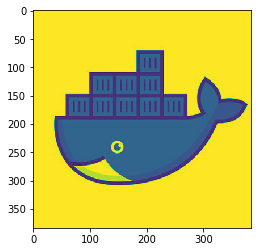

In [55]:
plt.imshow(img);

In [85]:
o = 1
axis = (10.,10.)
print(axis)
zoom_img = zoom(img, axis, order=o)

(10.0, 10.0)


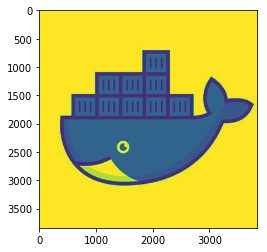

In [86]:
plt.imshow(zoom_img);

In [93]:
k = 10
img_t = torch.from_numpy(img) 
new_size = new_size = torch.Size([int(img_t.shape[i]*10) for i in range(img_t.dim())])
img_upsample = torch.nn.functional.upsample(img_t.unsqueeze(0).unsqueeze(0), size=new_size, mode='bilinear')
#interpolate(a_t, size=tuple(np.array(new_size).astype(int)), mode='linear')

/nmnt/media/home/ayagoz/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/nmnt/media/home/ayagoz/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


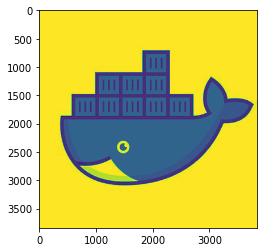

In [94]:
img_upsample = img_upsample.squeeze(0).squeeze(0)
plt.imshow(img_upsample);

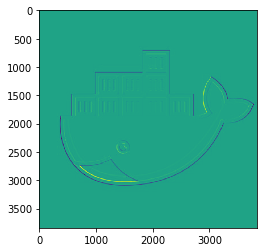

In [95]:
plt.imshow(zoom_img - img_upsample);

In [84]:
k = 10.
grid = identity_mapping((img.shape[0]*k, img.shape[1]*k))
zoomed_grid = grid/k

In [85]:
image = torch.FloatTensor(img).cuda()
sample_x = torch.FloatTensor(zoomed_grid[0]).cuda()#.unsqueeze(0)
sample_y = torch.FloatTensor(zoomed_grid[1]).cuda()
vf_image = bilinear_grid_sample(image, sample_x, sample_y)

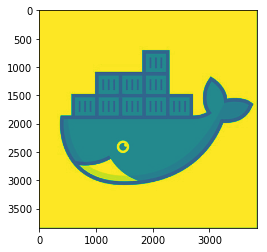

In [86]:
plt.imshow(vf_image.cpu().numpy());

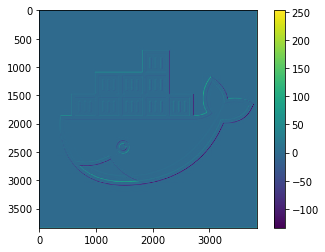

In [87]:
plt.imshow(zoom_img - vf_image.cpu().numpy());
plt.colorbar();

In [88]:
img.max(), img.min()

(254.97449999999998, 56.803799999999995)